In [3]:
import nibabel
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import time
from pprint import pprint
import cv2
from glob import glob
import os
import random
import gc
import shutil
!pip install pqdm
from pqdm.processes import pqdm

In [4]:
## Make slices
volumes = glob('/kaggle/input/liver-tumor-segmentation/volume*/*.nii')
volumes2 = glob('/kaggle/input/liver-tumor-segmentation-part-2/volume*/*.nii')
volumes.extend(volumes2)

In [5]:
dataset = {}
segmentation_root = '/kaggle/input/liver-tumor-segmentation/segmentations/'

for v in volumes:
    base = os.path.basename(v)
    segmentation = os.path.join(segmentation_root, base.replace('volume', 'segmentation'))
    if os.path.exists(segmentation):
        dataset[v] = segmentation

In [6]:
def rescale_image(img: np.ndarray, low=0, high=255, dtype=np.uint8):
    if img.min() == img.max():
        return np.ones_like(img) * img.min()

    return np.interp(
        img,
        (img.min(), img.max()),
        (low, high),
    ).astype(dtype)

def nii_to_png(nii_file, png_root):
    base = os.path.basename(nii_file).replace('.nii', '')
    
    folder_name = os.path.join(png_root.replace('.nii', ''), base)
    if os.path.exists(folder_name):
        shutil.rmtree(folder_name)
        
    os.mkdir(folder_name)
    
    nii_img = nibabel.load(nii_file).get_fdata()
    depth = nii_img.shape[2]
    for d in range(0, depth):
        png_file_name = os.path.join(folder_name, f"{d}.png")
        png_file_data = cv2.resize(rescale_image(nii_img[:, :, d]), (256, 256))
        cv2.imwrite(png_file_name, png_file_data)


In [7]:
#!mkdir /kaggle/working/masks_png
# nii_to_png("/kaggle/input/liver-tumor-segmentation/segmentations/segmentation-28.nii", '/kaggle/working/masks_png')

In [8]:
# def process(args):
#     dat, seg = args
#     #     nii_to_png(dat, '/kaggle/working/images_png')
#     nii_to_png(seg, '/kaggle/working/masks_png')
    
# pqdm(dataset.items(), process, n_jobs=4)

In [9]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import IoU

import numpy as np
import cv2
from glob import glob

In [10]:
def unet(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Middle
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)

    # Decoder
    up5 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(drop4)
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv5)
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    # Output
    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [11]:
class DataGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=32, image_size=(256, 256)):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, index):
        batch_image_paths = self.image_paths[index * self.batch_size : (index + 1) * self.batch_size]
        batch_mask_paths = self.mask_paths[index * self.batch_size : (index + 1) * self.batch_size]

        images = []
        masks = []

        for image_path, mask_path in zip(batch_image_paths, batch_mask_paths):
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = np.expand_dims(image, axis=-1)

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = np.expand_dims(mask, axis=-1)
            mask = (mask > 0).astype(np.float32)

            images.append(image)
            masks.append(mask)

        return np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32)

In [12]:
image_files = glob('/kaggle/working/images_png/**/*.png')
mask_files = glob('/kaggle/working/masks_png/**/*.png')

no_file = []
no_file2 = []
for i in mask_files:
    # if not os.path.join('./Task03_Liver/images_png', os/.path.basename(i)) in image_files:
    if not os.path.exists(i.replace('masks', 'images').replace('segmentation', 'volume')):
        no_file.append(i)

for i in image_files:
    if not os.path.exists(i.replace('images', 'masks').replace('volume', 'segmentation')):
        no_file2.append(i)

In [13]:
print(f"""
Total images: {len(image_files)}
Masks:        {len(mask_files)}
No-Masks:     {len(no_file)}
No-Image:     {len(no_file2)} {no_file2}
""")


Total images: 58638
Masks:        58638
No-Masks:     0
No-Image:     0 []



In [14]:
final_images, final_masks = [], []
for i in image_files:
    mask = i.replace('images', 'masks').replace('volume', 'segmentation')
    if os.path.exists(i) and os.path.exists(mask):
        final_images.append(i)
        final_masks.append(mask)

print(f'Final images: {len(final_images)} {len(final_masks)}')

image_train, image_test, mask_train, mask_test = train_test_split(final_images, final_masks, test_size=0.1, random_state=42)
image_train = image_train[:10000]
image_test = image_test[:1000]
mask_train = mask_train[:10000]
mask_test = mask_test[:1000]
data_generator = DataGenerator(image_train, mask_train)
print(len(image_train), len(image_test))

Final images: 58638 58638
10000 1000


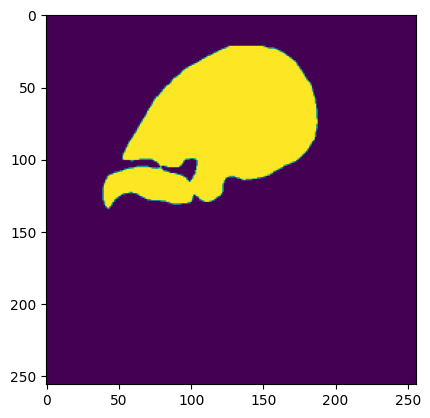

In [28]:
plt.imshow(cv2.imread(mask_test[30], cv2.IMREAD_GRAYSCALE))

In [15]:
checkpoint = ModelCheckpoint('/kaggle/working/model_checkpoint.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=1)

In [16]:
import tensorflow as tf

def dice_coefficient(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2.0 * intersection + 1e-5) / (union + 1e-5)
    return dice

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coefficient(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(tf.clip_by_value(y_true + y_pred, 0, 1))
    iou = (intersection + 1e-5) / (union + 1e-5)
    return iou

def iou_loss(y_true, y_pred):
    return 1.0 - iou(y_true, y_pred)

def dice_iou_loss(y_true, y_pred):
    return 0.5 * iou_loss(y_true, y_pred) + 0.5 * dice_loss(y_true, y_pred)

In [17]:
model = unet(input_size=(256, 256, 1))
model.compile(optimizer=tf.keras.optimizers.AdamW(0.00001), loss=dice_loss,
              metrics=[iou, dice_coefficient])

In [18]:
raise Exception('Dont fit model.')
history = model.fit(data_generator, epochs=50,
                    validation_data=DataGenerator(image_test, mask_test),
                    batch_size=64, callbacks=[checkpoint])

Exception: Dont fit model.

In [19]:
model.load_weights('/kaggle/working/model_checkpoint.h5')

In [23]:
prediction = model.evaluate(DataGenerator(image_test, mask_test))

31/31 [==============================] - 12s 360ms/step - loss: 0.1741 - iou: 0.7124 - dice_coefficient: 0.8259


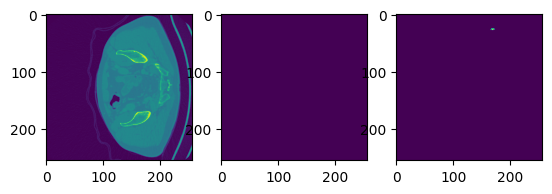

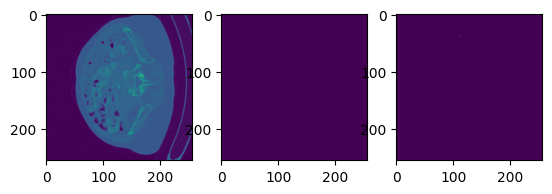

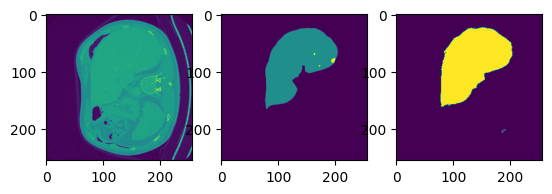

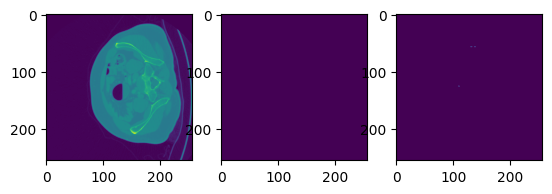

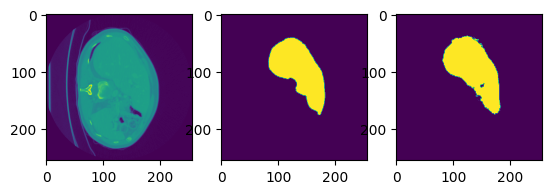

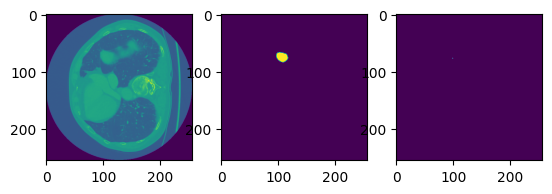

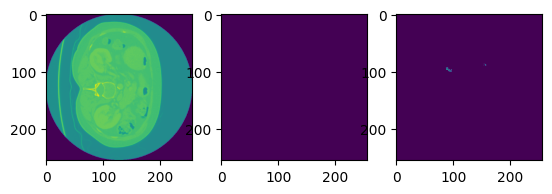

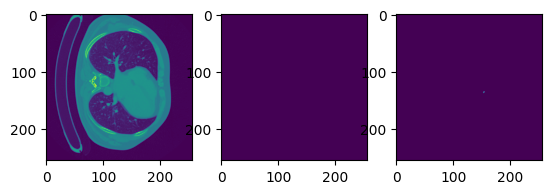

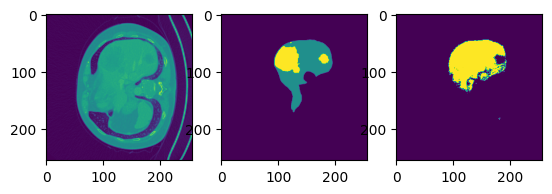

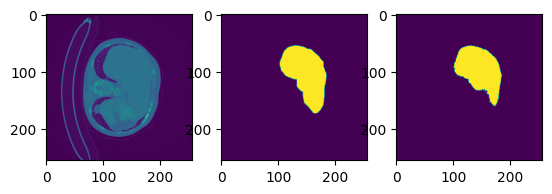

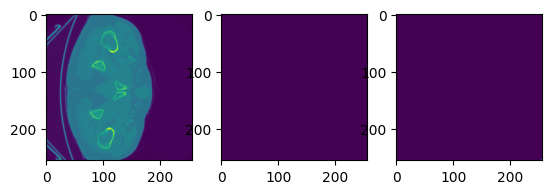

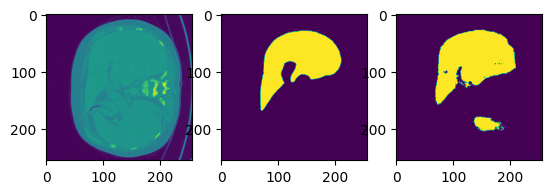

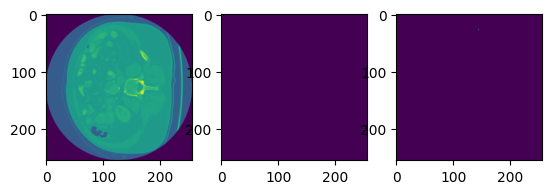

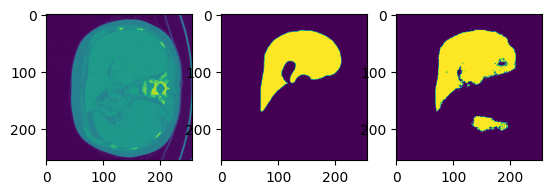

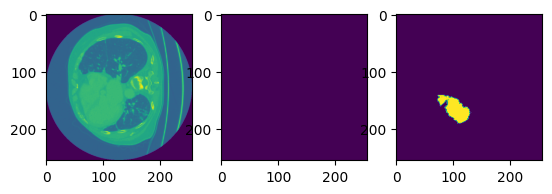

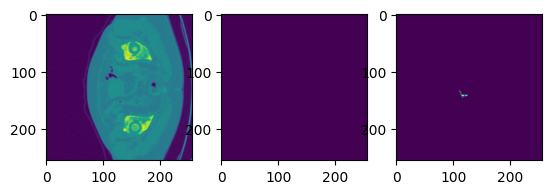

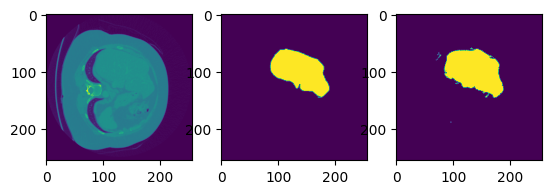

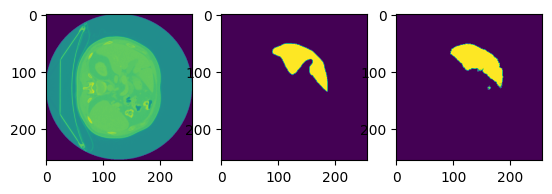

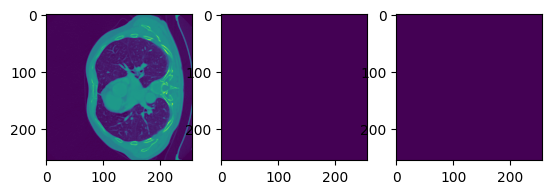

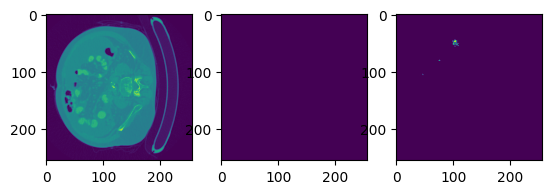

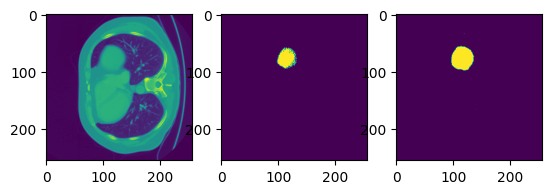

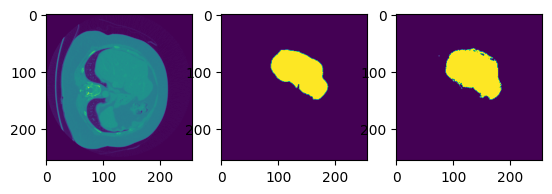

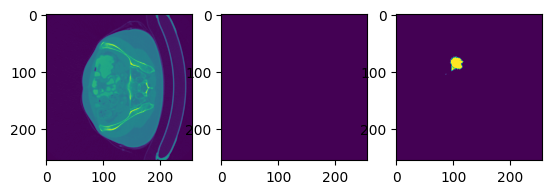

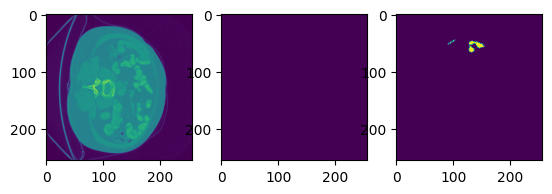

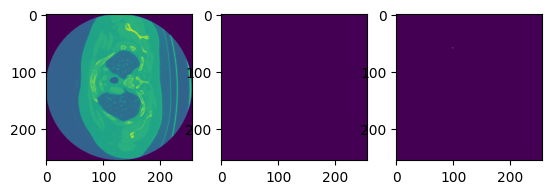

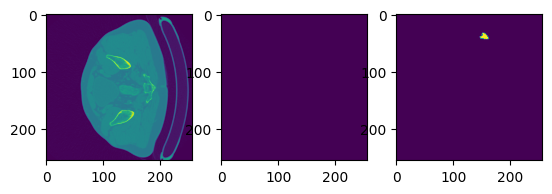

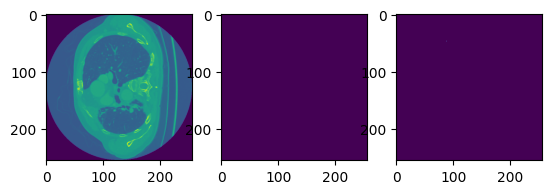

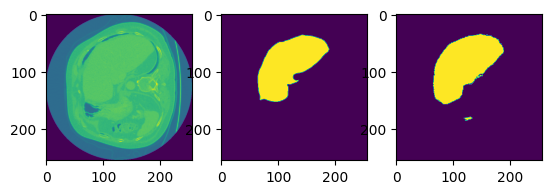

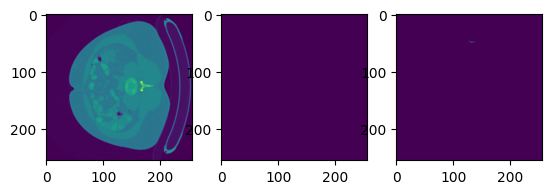

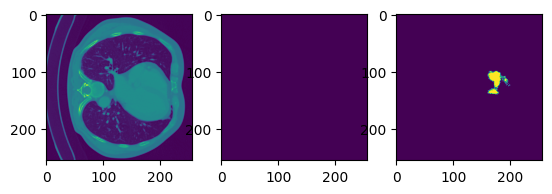

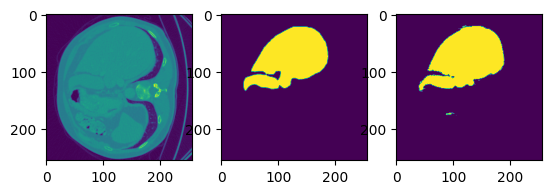

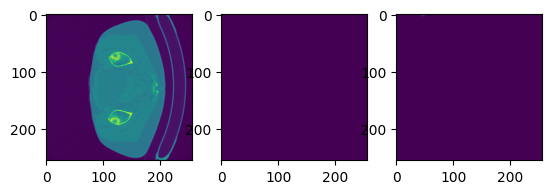

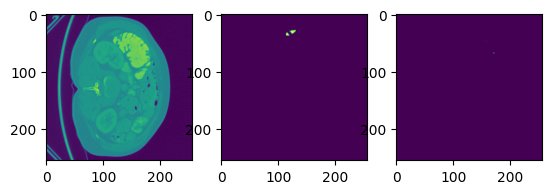

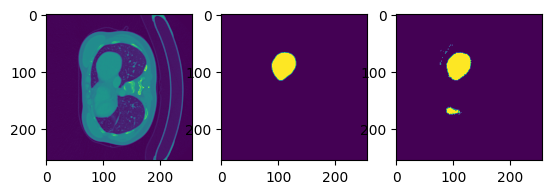

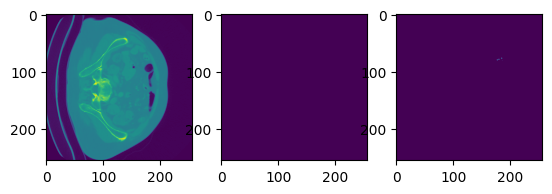

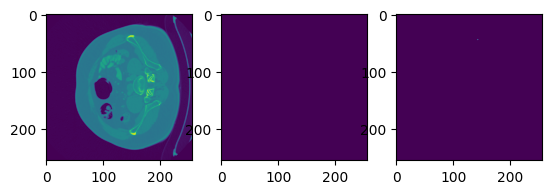

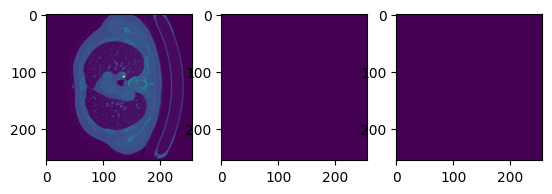

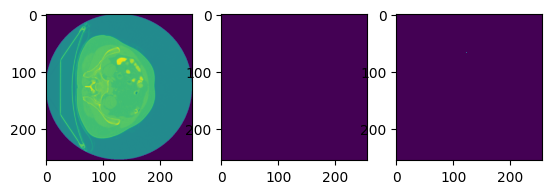

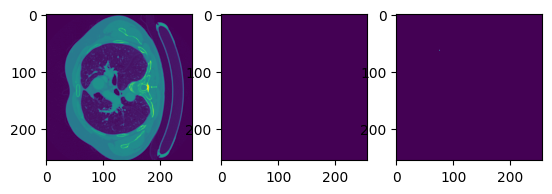

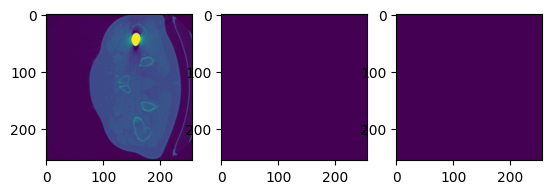

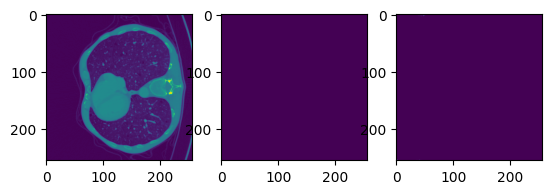

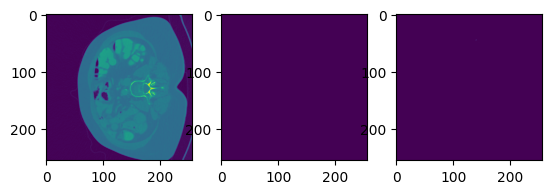

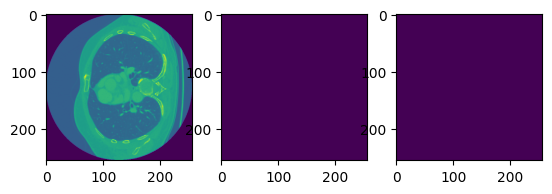

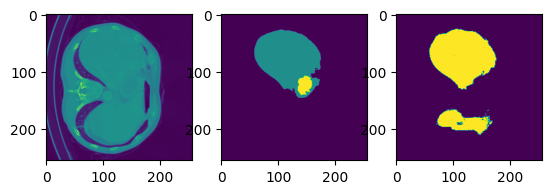

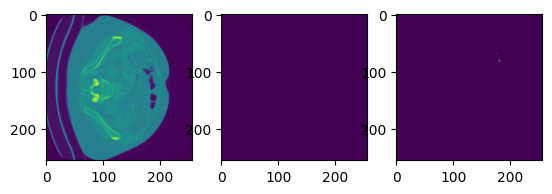

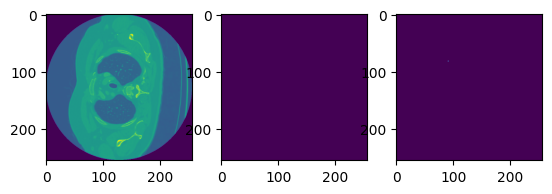

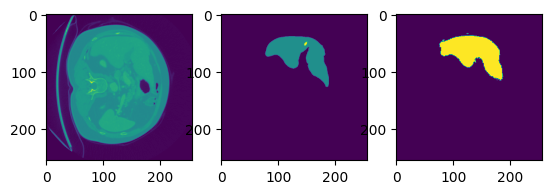

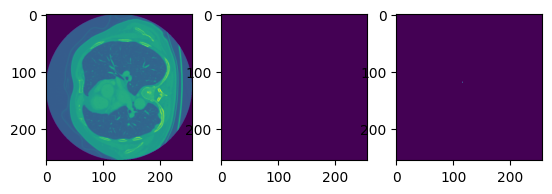

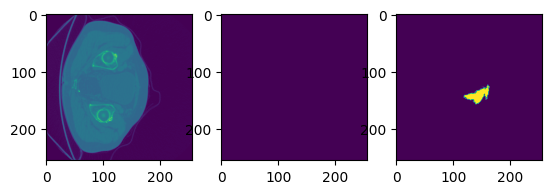

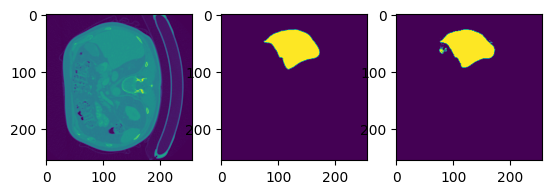

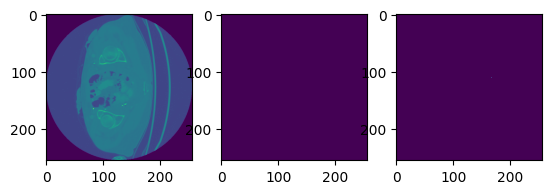

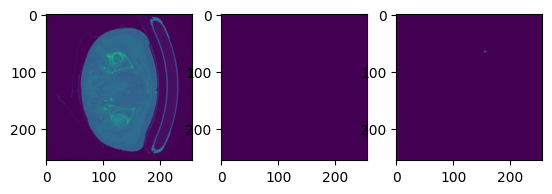

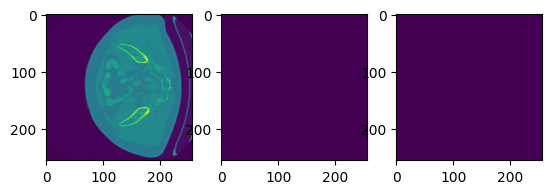

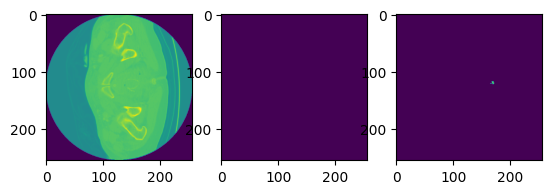

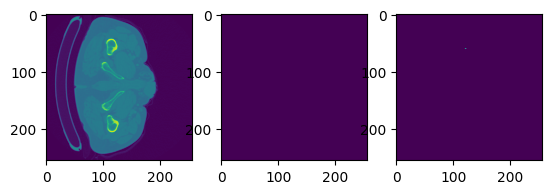

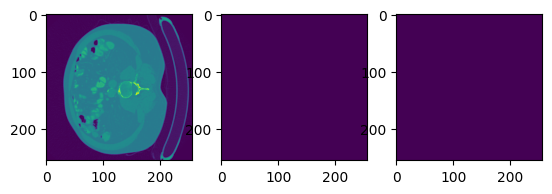

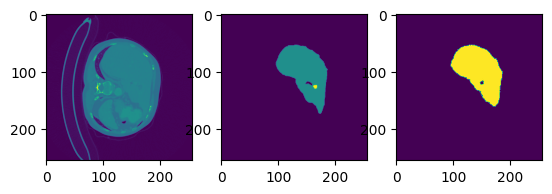

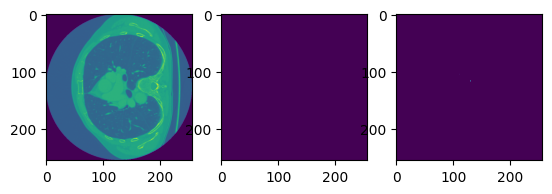

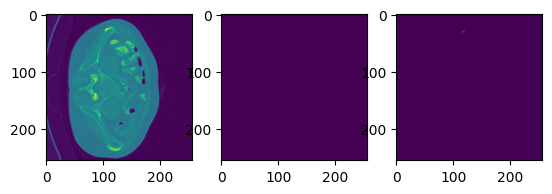

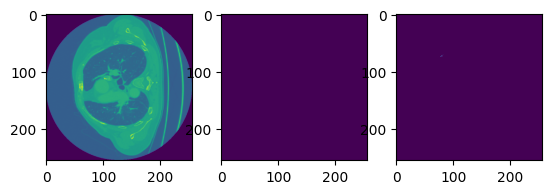

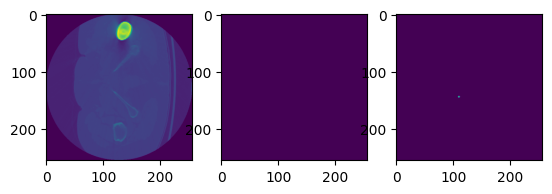

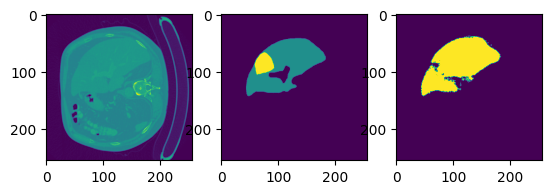

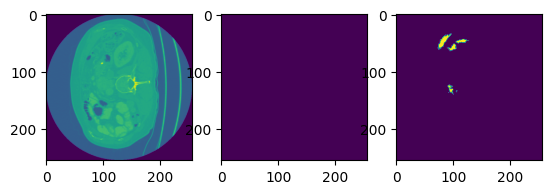

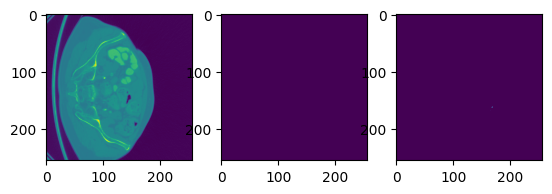

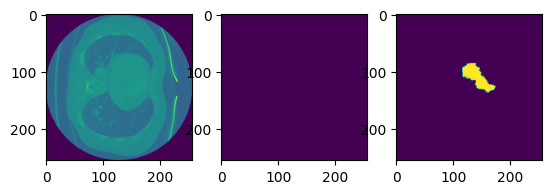

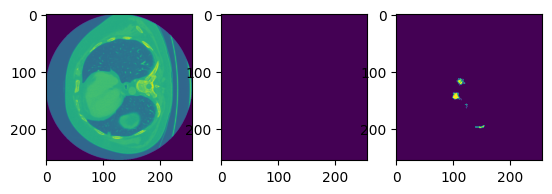

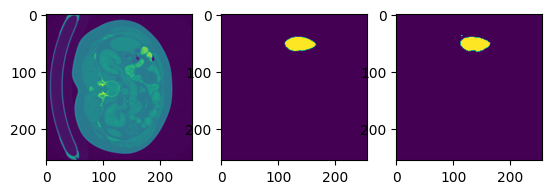

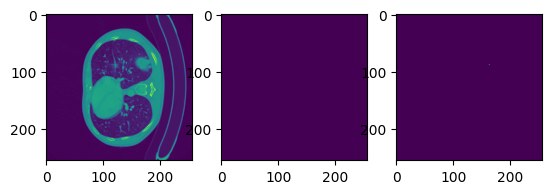

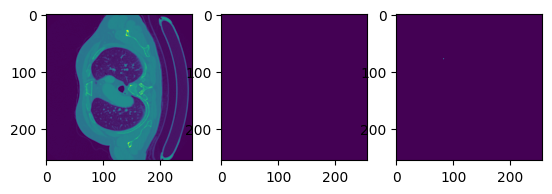

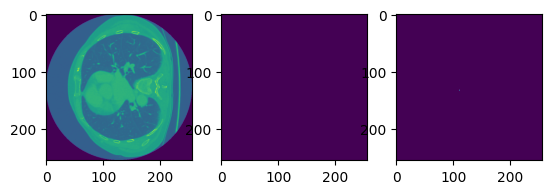

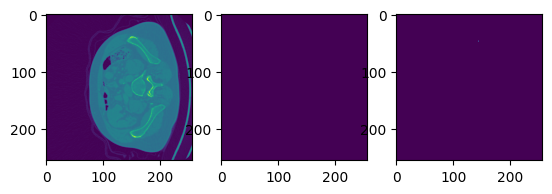

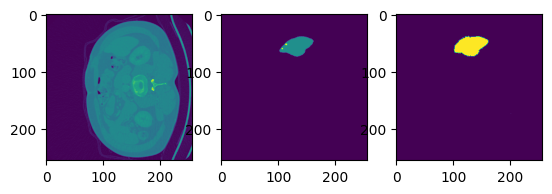

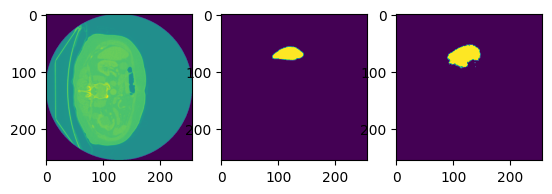

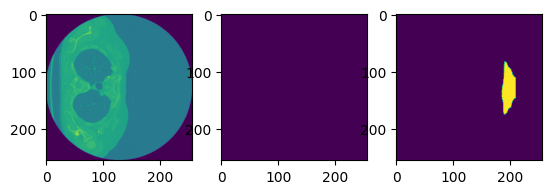

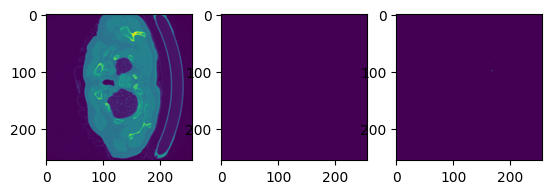

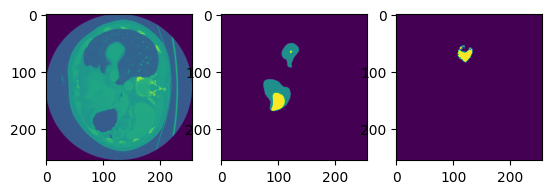

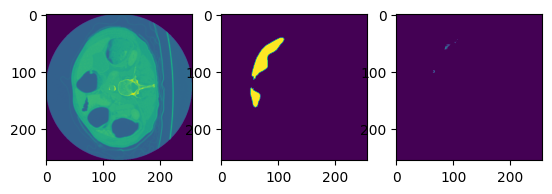

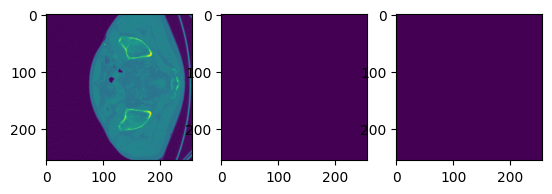

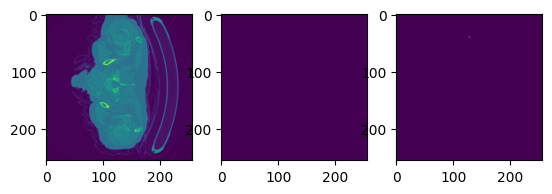

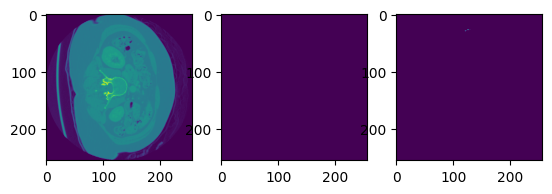

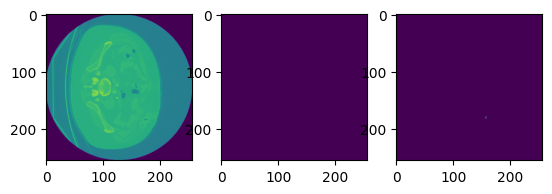

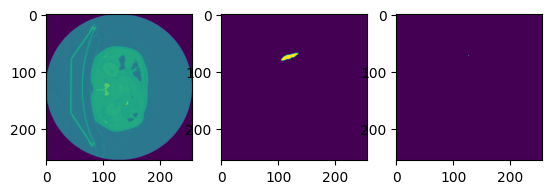

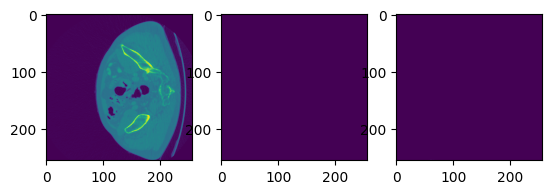

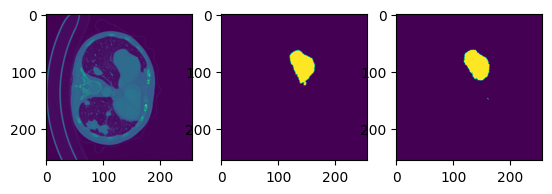

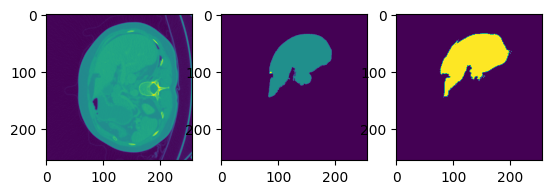

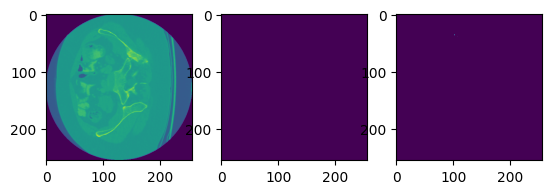

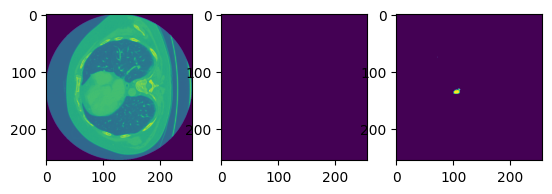

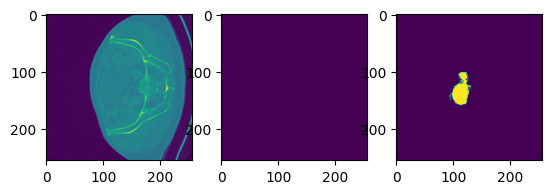

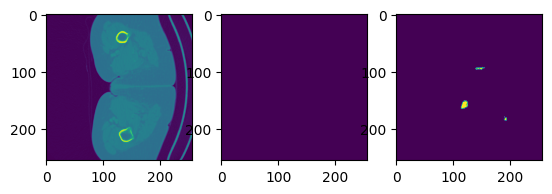

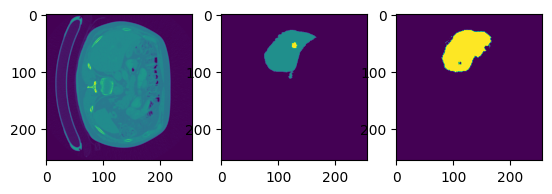

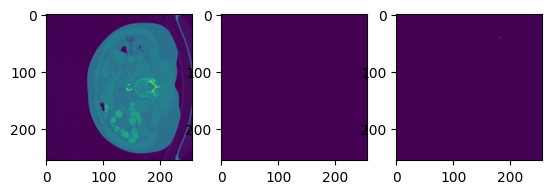

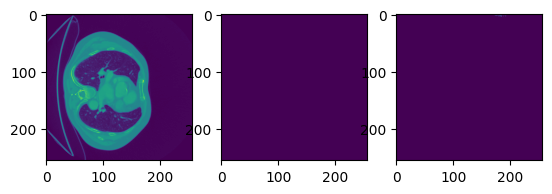

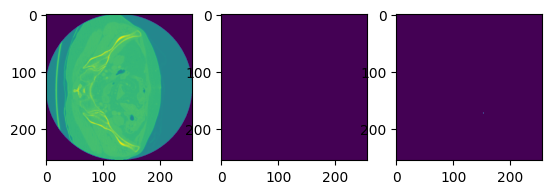

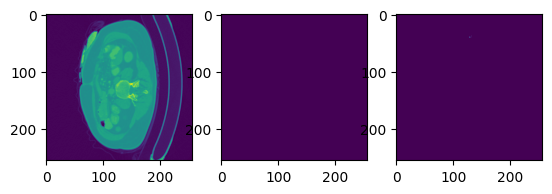

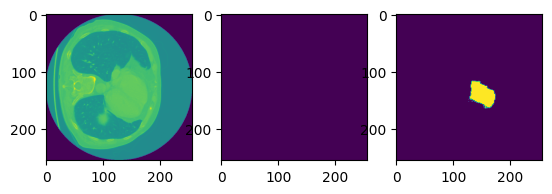

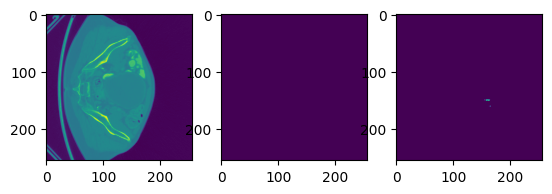

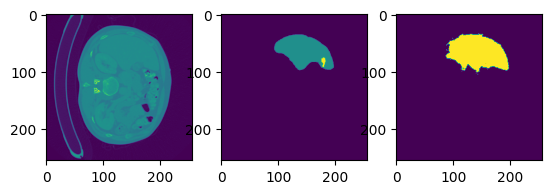

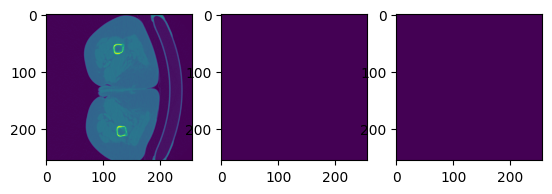

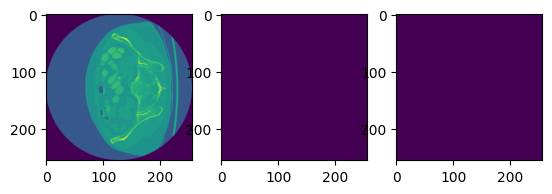

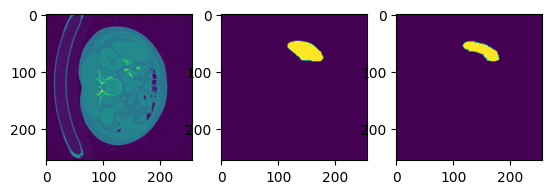

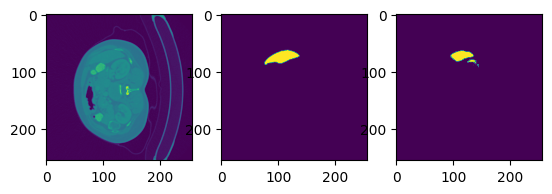

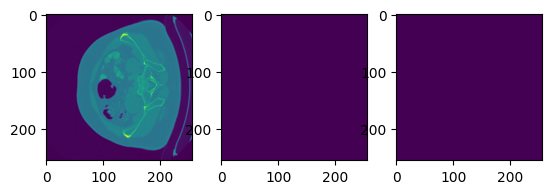

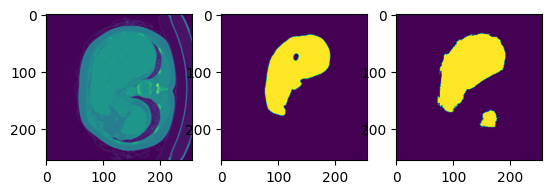

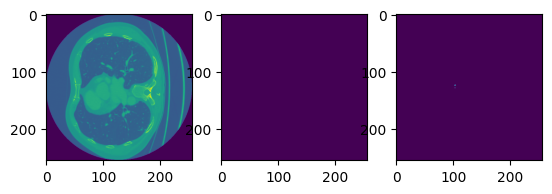

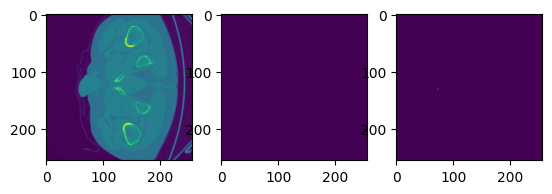

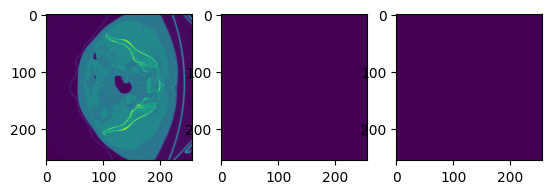

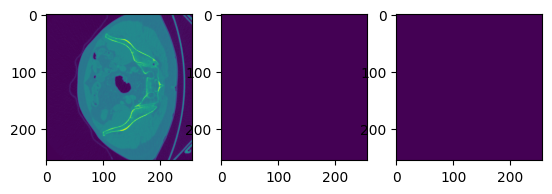

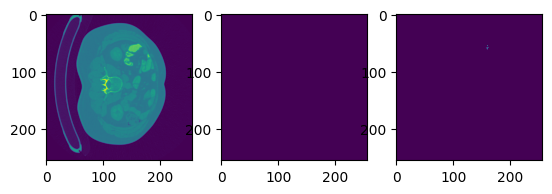

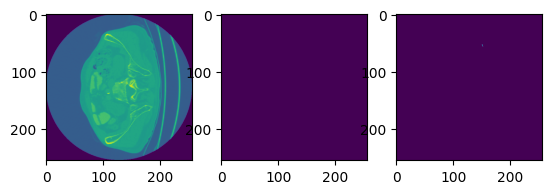

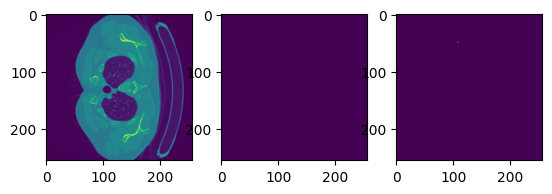

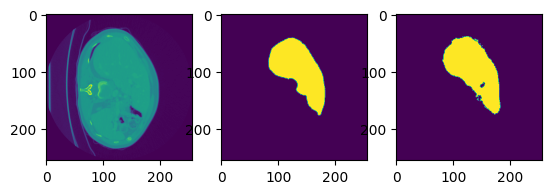

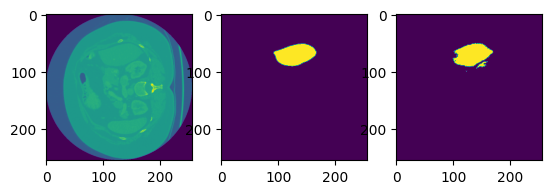

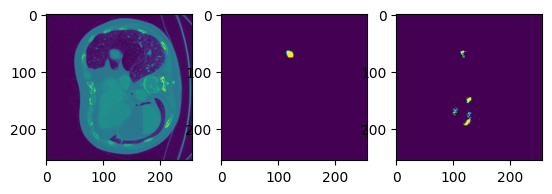

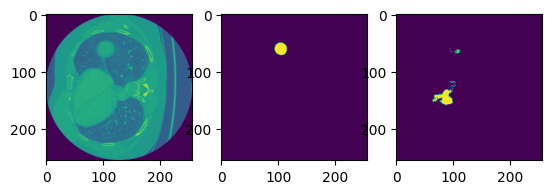

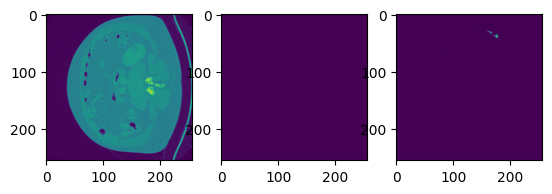

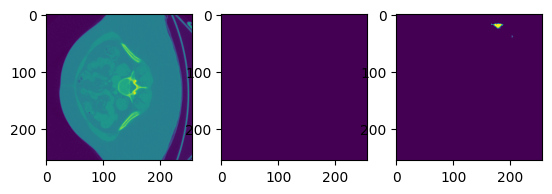

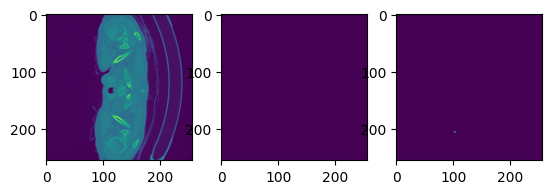

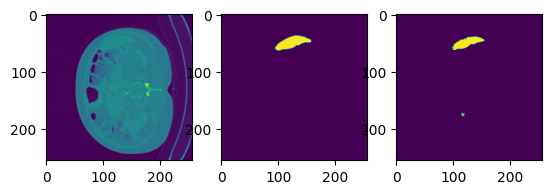

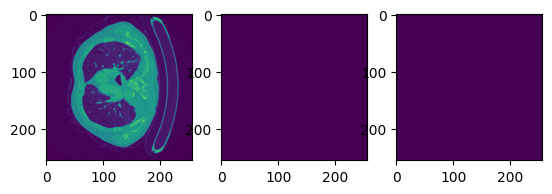

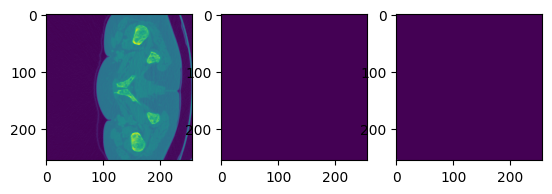

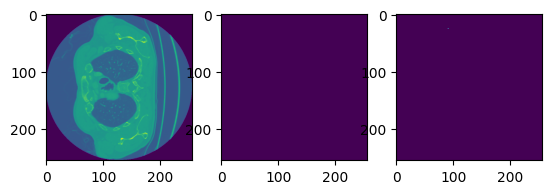

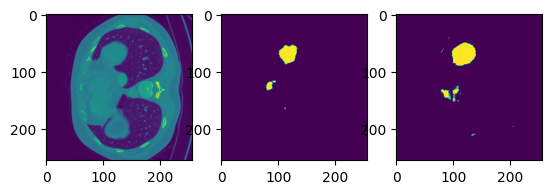

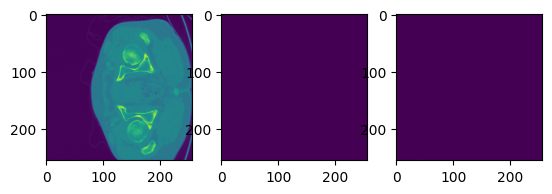

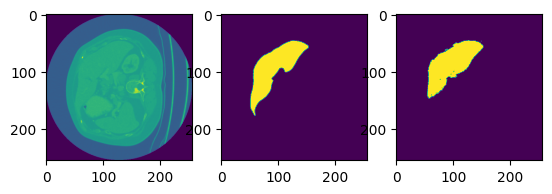

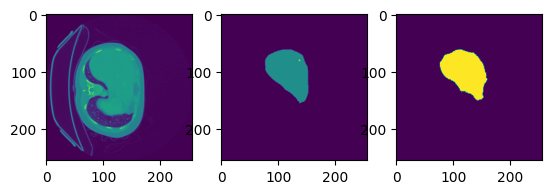

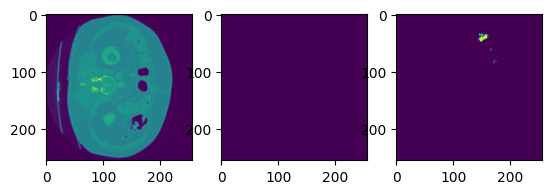

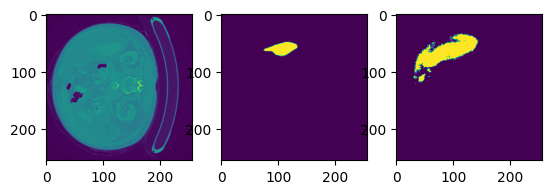

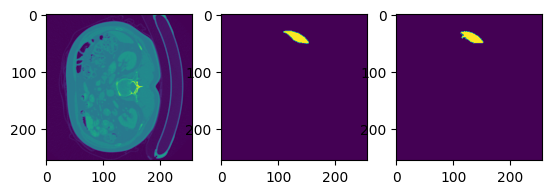

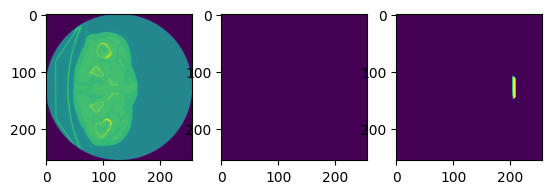

KeyboardInterrupt: 

In [22]:
from PIL import Image

for i, j, k in zip(image_test, mask_test, prediction):
    plt.subplot(1, 3, 1)
    plt.imshow(Image.open(i))
    
    plt.subplot(1, 3, 2)
    plt.imshow(Image.open(j))
    
    plt.subplot(1, 3, 3)
    plt.imshow(k)
    plt.show()

In [ ]:
history2 = model.fit(data_generator, epochs=5,
                    validation_data=DataGenerator(image_test, mask_test),
                    batch_size=64, callbacks=[checkpoint])